# Annexe

Dans l'OpenData d'IDFM, en plus des validations sur le réseau ferré, il y a aussi des données de validation sur le réseau de surface, c'est-à-dire les lignes de bus et de tramway. Cependant, ces données de validations sont différentes de celles du réseau ferré. Pour le réseau ferré nous avions des données sur des stations (La Défense, Châtelet...), alors que pour le réseau de surface nous avons des données sur des lignes (le bus 30, le tramway T2...) car les valideurs sont situés directement à bord des bus ou des tramways. Ces données ne rentrent donc pas dans notre sujet, mais peuvent tout de même montrer des résultats intéressants. On se propose de les étudier dans une annexe.

### Importations

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
import json
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
import matplotlib.pyplot as plt
import seaborn as sns

## I. Validations sur le réseau de surface (RDS)

In [55]:
df_rds = pd.read_csv("../data/validations/validations_rds.csv",sep = ";")
df_rds = df_rds.rename(columns={"jour":"JOUR","libelle_ligne":"LIBELLE_LIGNE","id_groupofligne":"ID_GROUPOFLIGNE","nb_vald":"NB_VALD"})

vald_rds = (
    df_rds.groupby(['ID_GROUPOFLIGNE', 'LIBELLE_LIGNE'], as_index=False)['NB_VALD']
    .sum()
    .sort_values(by='NB_VALD', ascending=False)
)

# Chaque ligne a un identifiant unique : ID_GROUPOFLIGNE

vald_rds['NB_VALD_MOY_JOUR'] = (vald_rds['NB_VALD']/91).round(0) #pour arrondir : round(0)
vald_rds = vald_rds[vald_rds["ID_GROUPOFLIGNE"] != "A00000"] #on enlève les lignes non-définies
vald_rds.head(10)

,ID_GROUPOFLIGNE,LIBELLE_LIGNE,NB_VALD,NB_VALD_MOY_JOUR
981,A01193,T3a,10700314,117586.0
1228,A01757,T3b,10662056,117165.0
980,A01192,T2,8621139,94738.0
1414,A02371,T9 - Paris Porte de Choisy - Orly Gaston Viens,5622812,61789.0
736,A00924,TVM,4912649,53985.0
1268,A02149,T6,4029208,44277.0
763,A00952,62,2776453,30510.0
1269,A02150,T8,2488586,27347.0
1231,A01760,T5,2460480,27038.0
761,A00950,60,1821021,20011.0


Note : toutes les lignes qui ont un nom commençant par un T sont des tramways, sauf le TVM qui est un bus.

Les lignes les plus fréquentées du réseau de surface sont surtout des lignes de tramways, c'est plutôt logique car un tramway peut contenir bien plus de personnes qu'un bus.
La ligne la plus fréquentée du réseau de surface est le T3a, suivie de près par le T3b. Ces deux lignes réunies ont un trajet faisant le tour de Paris. Ce sont les seules lignes de tramways ayant un trajet intégralement intra-muros.

La ligne de bus la plus fréquentée d'Ile de France est le TVM (TVM est pour Trans Val de Marne). Comme son nom l'indique, elle traverse le département du Val de Marne d'Est en Ouest. C'est une des rares lignes d'Ile de France pouvant être qualifiée de BHNS (Bus à Haut Niveau de Service), car elle bénéficie d'un site propre sur la quasi-intégralité de son trajet. C'est-à-dire que les bus roulent sur une voie qui leur exclusivement réservée, et ont la priorité aux intersections. Cela permet de gagner énormément de temps sur le trajet.

Remarque : En plus d'être le bus le plus fréquenté d'Ile de France comme on le constate ici, le TVM est le bus le plus fréquenté d'Europe !

## II. Fréquence des lignes

### II. 1. Statistiques descriptives

In [56]:
gtfs_dir = "../data/gtfs"
gtfs_dir = Path(gtfs_dir)

calendar = pd.read_csv(gtfs_dir / "calendar.txt")
trips = pd.read_csv(gtfs_dir / "trips.txt")
stop_times = pd.read_parquet(gtfs_dir / "stop_times.parquet")
stops = pd.read_csv(gtfs_dir / "stops.txt")
calendar_dates = pd.read_csv(gtfs_dir / "calendar_dates.txt")
routes = pd.read_csv(gtfs_dir / "routes.txt")

# Trouver automatiquement un lundi hors vacances de Noël

calendar_tmp = calendar.copy()

# Convertir les dates GTFS en datetime
calendar_tmp["start_date_dt"] = pd.to_datetime(calendar_tmp["start_date"], format="%Y%m%d")
calendar_tmp["end_date_dt"]   = pd.to_datetime(calendar_tmp["end_date"],   format="%Y%m%d")

candidates = []

for _, row in calendar_tmp.iterrows():
    if row["monday"] != 1:
        continue

    # Générer tous les lundis dans l'intervalle de validité
    lundis = pd.date_range(
        start=row["start_date_dt"],
        end=row["end_date_dt"],
        freq="W-MON"
    )

    for d in lundis:
        # Exclure vacances de Noël
        if not (
            (d.month == 12 and d.day >= 20) or
            (d.month == 1  and d.day <= 5)
        ):
            candidates.append(d)

candidates = list(set(candidates)) #drop les doublons
# Deuxième lundi valide
candidates = sorted(candidates)
date = candidates[1]
print("Date retenue pour l'analyse :", date.date())

dint = int(date.strftime("%Y%m%d"))

/tmp/ipykernel_156895/464959643.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv(gtfs_dir / "trips.txt")


Date retenue pour l'analyse : 2025-12-08


In [57]:
services_jour = (calendar.groupby(
    ["start_date"],as_index=False)["service_id"].nunique()
) #nombre de services qui commencent tel jour

#Services actifs sur notre date
actifs = calendar[
    (calendar["start_date"] <= dint) &
    (calendar["end_date"]   >= dint) &
    calendar["monday"] == 1 #indispensable
]["service_id"]

#Exceptions
exceptions = calendar_dates[calendar_dates["date"] == dint]
actifs = pd.Index(actifs).unique()

enlever = pd.Index(exceptions.loc[exceptions["exception_type"] == 2, "service_id"]).unique()
ajouter = pd.Index(exceptions.loc[exceptions["exception_type"] == 1, "service_id"]).unique()
#loc : sert à sélectionner certaines lignes et certaines colonnes, avec potentiellement des booléens

actifs = actifs.difference(enlever)
actifs = actifs.union(ajouter)
d_actifs = {}
for service_id in actifs :
    d_actifs[service_id] = 1

trips_0812 = trips.loc[trips["service_id"].isin(actifs)]
#isin : vérifie pour chaque élément du DataFrame s'il est dans actifs

offre = trips_0812.merge(routes,on="route_id",how="left")
offre = offre[["route_id","route_long_name","trip_id","direction_id"]]

# Heure (ou minute) de départ du trip au premier arrêt
st = stop_times.loc[stop_times["trip_id"].isin(offre["trip_id"])].copy()
st = st.sort_values(["trip_id", "stop_sequence"])
first_dep = st.groupby("trip_id", as_index=False).first()[["trip_id", "departure_time"]]

# Conversion de HH:MM:SS en minutes depuis 00:00 (gère par ex "25:10:00" si nécessaire)
def to_min(t):
    #marche même si t dépasse 24:00:00
    h, m, s = map(int, t.split(":"))
    return h*60 + m + s/60

first_dep["dep_min"] = first_dep["departure_time"].map(to_min)

dep = first_dep.merge(offre[["trip_id","route_id","direction_id"]], on="trip_id", how="left")

# Pointe du matin 7h–10h
peak = dep[(dep["dep_min"] >= 7*60) & (dep["dep_min"] < 10*60)]

freq = (peak.groupby(["route_id","direction_id"], as_index=False)
             .size()
             .rename(columns={"size": "voyages_3h"}))
freq["voyages_h"] = freq["voyages_3h"] / 3.0
freq["headway_min"] = 60.0 / freq["voyages_h"]

freq = freq.merge(
    routes[["route_id","route_type","route_long_name"]],
    on="route_id", how="left"
)
freq = freq.sort_values(by="voyages_h",ascending=False)
# Chaque ligne apparait 2 fois dans la liste, une fois pour chaque sens

freq = freq.drop_duplicates(subset="route_long_name",keep="first") 
freq.head(10)

,route_id,direction_id,voyages_3h,voyages_h,headway_min,route_type,route_long_name
2065,IDFM:C01742,1,138,46.000000,1.304348,2,A
2063,IDFM:C01740,1,114,38.000000,1.578947,2,L
2054,IDFM:C01728,1,107,35.666667,1.682243,2,D
1664,IDFM:C01371,1,105,35.000000,1.714286,1,1
1687,IDFM:C01383,0,103,34.333333,1.747573,1,13
2066,IDFM:C01743,1,102,34.000000,1.764706,2,B
2059,IDFM:C01737,1,102,34.000000,1.764706,2,H
2062,IDFM:C01739,1,101,33.666667,1.782178,2,J
2053,IDFM:C01727,1,100,33.333333,1.800000,2,C
1689,IDFM:C01384,0,100,33.333333,1.800000,1,14


Les lignes les plus fréquentes en heure de pointe du matin en semaine ne sont que des lignes ferrées. En effet, beaucoup de lignes ferrées d'Ile de France transportent énormément de voyageurs, ce qui nécessite une grande fréquence. Fréquence rendue possible par le fait d'avoir des voies dédiées à une unique ligne. La ligne la plus fréquente est le RER A, avec en moyenne un train toutes les 1.3 minutes sur le tronçon central.

Restreignons maintenant au réseau de surface :

In [58]:
freq_rds = freq[(freq["route_type"] == 0) | (freq["route_type"] == 3)]
freq_rds.head(15)

,route_id,direction_id,voyages_3h,voyages_h,headway_min,route_type,route_long_name
1139,IDFM:C01071,0,62,20.666667,2.903226,3,TVM
1272,IDFM:C01142,1,54,18.000000,3.333333,3,113
1701,IDFM:C01390,0,52,17.333333,3.461538,0,T2
2160,IDFM:C01843,0,50,16.666667,3.600000,0,T4
1703,IDFM:C01391,0,48,16.000000,3.750000,0,T3a
1238,IDFM:C01123,1,47,15.666667,3.829787,3,92
1993,IDFM:C01679,0,47,15.666667,3.829787,0,T3b
2110,IDFM:C01794,1,47,15.666667,3.829787,0,T6
1510,IDFM:C01266,1,46,15.333333,3.913043,3,291
1252,IDFM:C01132,1,45,15.000000,4.000000,3,103


Nous remarquons la présence de beaucoup de lignes de tramway. Dans la même logique que les lignes ferrées, ces lignes transportent énormément de personnes donc doivent être très fréquentes, et bénéficient d'une voie dédiée. Cependant, la fréquence maximale d'une ligne de bus est plus élevée qu'une ligne de tramway, car le fait que le tramway soit contraint à rester sur des voies rend l'exploitation plus difficile. Il est par exemple impossible d'avoir deux tramways qui se suivent l'un collé à l'autre, alors que pour des bus cela ne pose pas de problème. 
C'est pour cette raison que la ligne la plus fréquente du réseau de surface est le TVM, qui combine à la fois le fait d'être un bus, et le fait d'avoir un site propre.

Autre remarque que nous pouvons faire sur ce classement : nous remarquons la présence de 5 lignes de bus exploitées avec des bus standards (113, 92, 291, 103, 129) et de 4 avec des bus articulés (TVM, Caméléon T1, 4606, 258). 
En effet, comme les bus standards peuvent transporter moins de personnes que les bus articulés, ils nécessitent une fréquence plus élevée sur les lignes très fréquentées.
(A notre connaissance il n'existe pas de base de données qui répertorie le matériel roulant de chaque ligne de bus, ces informations viennent de la page Wikipédia des lignes de bus RATP.)

Enfin, en tant qu'étudiants du plateau de Saclay, nous constatons que la ligne 4606, que (presque) tout étudiant de l'ENSAE a déjà prise au moins une fois, est la 5ème ligne de bus la plus fréquente d'Ile de France en heure de pointe avec un bus tous les 4 minutes en moyenne. Cette ligne relie les campus universitaires et les logements du plateau à la gare de Massy-Palaiseau, point de passage quasiment indispensable pour se rendre à Paris depuis le plateau.
On peut rajouter que le tracé du 4606 va être entièrement repris par la ligne 18 du Grand Paris Express, qui devrait être mise en service fin 2026, avec moins de points d'arrêts. Le 4606 risque donc de voir son offre baisser et de ne plus être dans ce classement d'ici 1 an.

En effet, rappelons que dans ce classement nous regardons la fréquence de ces lignes en heure de pointe. Ainsi, la ligne 4606 n'est pas impactée par sa fréquence pas si élevée d'un bus tous les 15 minutes en heure creuse.

En guise de parenthèse, étudions le réseau de bus de Paris-Saclay, car c'est le secteur de l'ENSAE, donc d'une certaine manière cela nous concerne directement !

In [59]:
routes = routes[["agency_id","route_id"]]
freq_routes = freq.merge(routes,on="route_id",how="left")
freq_saclay = freq_routes[freq_routes["agency_id"] == "IDFM:1060"] #restriction à Paris-Saclay
freq_saclay = freq_saclay[["route_id","route_long_name","voyages_h","headway_min"]]
freq_saclay

,route_id,route_long_name,voyages_h,headway_min
36,IDFM:C01567,4606,15.000000,4.000000
71,IDFM:C01561,4609,11.000000,5.454545
81,IDFM:C01697,4602,10.000000,6.000000
213,IDFM:C00495,4611,6.666667,9.000000
232,IDFM:C00068,4603,6.000000,10.000000
255,IDFM:C00687,4644,6.000000,10.000000
269,IDFM:C00072,4607,5.666667,10.588235
316,IDFM:C01698,4621,5.333333,11.250000
395,IDFM:C01699,4622,4.666667,12.857143
405,IDFM:C00069,4604,4.666667,12.857143


Nous remarquons trois lignes très fréquentes : le 4606 qu'on a déjà vu avant, ainsi que le 4609 et le 4602. 

Le 4609 complète la desserte du plateau de Saclay du 4606, en reliant le campus d'HEC et le secteur de l'université Paris-Saclay à la gare du Guichet, et à Orsay et aux Ulis.

Enfin, la ligne 4602 emprunte l'autoroute A10 depuis la gare de Massy-Palaiseau et dessert la zone industrielle de Courtaboeuf, ainsi que les villes d'Orsay et des Ulis.

Certaines lignes ont des fréquences très basses (par exemple, 1 bus tous les 3h en moyenne) car ce sont des lignes scolaires. Elles sont dédiées à une demande très ciblée.

### II. 2. Régression

Merge offre et demande :

In [60]:
#On doit pour cela utiliser le fichier ref_lignes.csv qui contient tous les identifiants uniques des lignes

ref = pd.read_csv("../data/ref/ref_lignes.csv",sep=";")
ref["route_id"] = "IDFM:" + ref["id_line"]
ref = ref[["route_id","id_groupoflines"]]
ref = ref.rename(columns={"id_groupoflines":"ID_GROUPOFLIGNE"})
vald = vald_rds.merge(ref,on="ID_GROUPOFLIGNE",how="inner")

freq_vald = freq_rds.merge(vald,on="route_id",how="inner")
freq_vald = freq_vald[["route_id","route_long_name","voyages_3h","headway_min","NB_VALD_MOY_JOUR"]]
freq_vald = freq_vald.sort_values(by="NB_VALD_MOY_JOUR",ascending=False)
freq_vald.head(5)

,route_id,route_long_name,voyages_3h,headway_min,NB_VALD_MOY_JOUR
3,IDFM:C01391,T3a,48,3.750000,117586.0
5,IDFM:C01679,T3b,47,3.829787,117165.0
2,IDFM:C01390,T2,52,3.461538,94738.0
15,IDFM:C02317,T9,43,4.186047,61789.0
0,IDFM:C01071,TVM,62,2.903226,53985.0


In [61]:
df = freq_vald.copy()

# remplacer inf / -inf par NaN
df_clean = df.replace([np.inf, -np.inf], np.nan)

# supprimer toutes les lignes contenant un NaN
df_clean = df_clean.dropna()

y = df_clean["NB_VALD_MOY_JOUR"]
y_log = np.log(df_clean["NB_VALD_MOY_JOUR"] + 1)
X = df_clean[["voyages_3h"]]
X_log = np.log(df_clean[["voyages_3h"]] + 1)
X = sm.add_constant(X)

model = sm.OLS(y_log, X_log).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:       NB_VALD_MOY_JOUR   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                          3.008e+04
Date:                Thu, 18 Dec 2025   Prob (F-statistic):                        0.00
Time:                        13:27:00   Log-Likelihood:                         -2678.7
No. Observations:                1556   AIC:                                      5359.
Df Residuals:                    1555   BIC:                                      5365.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

En log-log : on a un R² de 0.95. Comme pour les stations et gares, l'offre et la demande sont très corrélées. Une augmentation de 1% de l'offre en heure de pointe est associée à, en moyenne, une augmentation de 2.7 % du nombre de validations.

On peut noter la présence d'outliers, comme pour le réseau : certaines lignes ont une offre très élevée sans pour autant être très fréquentées car leur trajet est court. Elles répondent à une demande ponctuelle. On peut citer par exemple le 291 (Pont de Sèvres <-> Vélizy) ou le 118 (Château de Vincennes <-> Val de Fontenay).

## III. Etude du trajet des lignes : longueur du trajet et POI

Pour expliquer la fréquentation des lignes de bus et de tramway, on se propose d'étudier leur trajet.

Nous avons pour cela le fichier shapes.csv qui, pour chaque ligne de transport d'Ile de France associe son tracé.

In [62]:
def shape_geojson_to_geom(x):
    """
    Convertit une valeur de la colonne 'shape' (string JSON ou dict)
    au format GeoJSON (LineString / MultiLineString) en géométrie shapely.

    Attendu dans ton cas :
      {"coordinates": [[[lon,lat],...], [[lon,lat],...]], "type": "MultiLineString"}
    """

    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None

    # Si c'est une string, la parser en dict
    if isinstance(x, str):
        try:
            x = json.loads(x)
        except Exception:
            return None

    if not isinstance(x, dict):
        return None

    geom_type = x.get("type")
    coords = x.get("coordinates")

    if coords is None:
        return None

    # helper : garder seulement lon/lat, même si [lon,lat,alt,...]
    def to_lonlat(pt):
        if isinstance(pt, (list, tuple)) and len(pt) >= 2:
            return (float(pt[0]), float(pt[1]))
        return None

    if geom_type == "LineString":
        pts = [to_lonlat(pt) for pt in coords]
        pts = [p for p in pts if p is not None]
        return LineString(pts) if len(pts) >= 2 else None

    if geom_type == "MultiLineString":
        lines = []
        for part in coords:  # part = [[lon,lat],...]
            pts = [to_lonlat(pt) for pt in part]
            pts = [p for p in pts if p is not None]
            if len(pts) >= 2:
                lines.append(LineString(pts))
        if not lines:
            return None
        return MultiLineString(lines) if len(lines) > 1 else lines[0]

    # Si jamais d'autres types apparaissent, on ignore
    return None

def poi_par_ligne(poi_path,rayon=200):
    """
    Calcule le nombre de POI à moins de "rayon" mètres du tracé (shape) de chaque ligne bus/tram.

    Requiert dans le fichier shapes :
      - route_id (et idéalement route_long_name)
      - route_type (ex: "Bus", "Tramway")
      - shape (GeoJSON-like avec coordinates lon/lat)
    Requiert dans les POI :
      - geometry (points), dans un parquet ou GeoDataFrame lisible par geopandas
    """
    df_shapes = pd.read_csv("../data/ref/shapes.csv",sep=";")

    # Filtrer bus/tram 
    rt = df_shapes["route_type"].astype(str)
    is_bus = rt.isin(("Bus",))
    is_tram = rt.isin(("Tram",))
    df_shapes = df_shapes[is_bus | is_tram].copy()

    # Géométries
    df_shapes["geometry"] = df_shapes["shape"].apply(shape_geojson_to_geom)
    df_shapes = df_shapes.dropna(subset=["geometry"])

    gdf_shapes = gpd.GeoDataFrame(df_shapes, geometry="geometry", crs="EPSG:4326")

    # Reprojection métrique + buffer
    gdf_shapes_2154 = gdf_shapes.to_crs("EPSG:2154")
    gdf_shapes_2154["geometry"] = gdf_shapes_2154.geometry.buffer(rayon)

    # Lire POI
    poi = gpd.read_parquet(poi_path)

    # Assurer CRS métrique
    if poi.crs is None or poi.crs.to_string() != "EPSG:2154":
        poi = poi.set_crs("EPSG:4326", allow_override=True).to_crs("EPSG:2154")

    # Identifiant POI (si tu n'en as pas)
    poi = poi.copy()
    poi["poi_id"] = poi.index

    # Jointure spatiale : POI dans buffer
    hits = gpd.sjoin(
        poi[["poi_id", "geometry"]],
        gdf_shapes_2154[["route_id", "route_long_name","geometry"]],
        how="inner",
        predicate="within"
    )

    # Compter les POI uniques par ligne
    out = (
        hits.groupby(["route_id", "route_long_name"])["poi_id"]
        .nunique()
        .reset_index()
        .rename(columns={"poi_id": "nb_poi"})
    )
    out = out.sort_values(by=f"nb_poi",ascending=False)

    return out


## III. 1. Etude du cas des logements

In [63]:
logement_lignes = poi_par_ligne("../data/poi/poi_logement.parquet")
logement_lignes.head(10)

,route_id,route_long_name,nb_poi
1338,IDFM:C01841,P,9254
1638,IDFM:C02413,95-50 (future 1143),5959
1035,IDFM:C01418,N14,5954
1037,IDFM:C01420,N12,5876
1344,IDFM:C01847,L,5328
1036,IDFM:C01419,N13,5308
1342,IDFM:C01845,N,5287
1345,IDFM:C01848,R,5005
1343,IDFM:C01846,J,4882
1033,IDFM:C01416,N16,4667


En regardant les logements, on se rend compte qu'on va devoir nettoyer les données : dans le classement, nous voyons des lignes P, L... Ces lignes correspondent à des remplacements des transiliens de la même lettre par des bus, par exemple en cas de travaux. Ces lignes ne circulent qu'occasionnellement, on va donc les exclure.

Nous allons aussi exclure les lignes ayant un nom avec un N puis un nombre, car ce sont des noctiliens : des bus circulant uniquement la nuit.

Pour cela, nous allons utiliser le fichier ref_lignes.csv qui liste toutes les lignes de transport d'Ile de France avec toutes leurs caractéristiques.

In [64]:
ref = pd.read_csv("../data/ref/ref_lignes.csv",sep=";")
ref = ref[["id_line","id_groupoflines","type"]]
ref = ref.rename(columns={"id_groupoflines":"ID_GROUPOFLIGNE"})
ref["route_id"] = "IDFM:" + ref["id_line"]
ref = ref[ref["type"].isna()] # Les bus de remplacements et autres lignes spéciales ont un "type" différent de NaN

filtre_special = logement_lignes.merge(ref,on="route_id",how="right")

filtre_nocti = filtre_special[~filtre_special["route_long_name"].str.contains("N", na=False)] 
# En réalité on enlève un peu plus que les noctiliens avec la condition "ne contient pas de N dans son nom", mais c'est négligeable

df_final = vald_rds.merge(filtre_nocti,on="ID_GROUPOFLIGNE",how="inner")

df_final = df_final[["route_id","route_long_name","nb_poi","NB_VALD"]]

df_final = df_final.sort_values(by="nb_poi",ascending=False)
df_final.head(10)

,route_id,route_long_name,nb_poi,NB_VALD
1116,IDFM:C02413,95-50 (future 1143),5959.0,8109
176,IDFM:C01084,39,4600.0,437066
129,IDFM:C01072,20,4439.0,577234
146,IDFM:C01093,56,3776.0,512622
1308,IDFM:C02555,6559,3747.0,4042
1387,IDFM:C02206,95-48 (future 1117),3693.0,3112
529,IDFM:C00774,1207,3674.0,95567
14,IDFM:C01083,38,3631.0,1605096
44,IDFM:C01073,21,3615.0,1012398
170,IDFM:C01079,29,3503.0,452478


On retrouve deux types de lignes dans celles qui desservent le plus de logements : des lignes de Paris intra-muros (toutes celles à deux chiffres) et des lignes de banlieue très longues.

Plus généralement : plus une ligne est longue, plus elle dessert une grande aire et donc plus elle desservira de POI.

## III. 2. Lien entre validations et longueur de la ligne

In [65]:
df_shape = pd.read_csv("../data/ref/shapes.csv",sep=";")

def aire_par_ligne(buffer_m=200):
    """
    Calcule l'aire desservie par ligne en bufferisant à buffer_m mètres autour du tracé.
    df_shape doit contenir :
      - une colonne 'shape' (GeoJSON string/dict)
    """

    df = df_shape.copy()

    # 1) Convertir shape -> geometry
    df["geometry"] = df["shape"].apply(shape_geojson_to_geom)
    df = df.dropna(subset=["geometry"])

    # 2) GeoDataFrame en WGS84
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

    # 3) Reprojeter en mètres + buffer
    gdf = gdf.to_crs("EPSG:2154")
    gdf["geometry"] = gdf.geometry.buffer(buffer_m)

    # 4) Union par ligne (évite double comptage)
    gdf_union = gdf.dissolve(by="route_id").reset_index()

    # 5) Aire
    gdf_union["area_m2"] = gdf_union.geometry.area

    return gdf_union[["route_id", "area_m2"]]

df_aire = aire_par_ligne()
vald = vald_rds.merge(ref,on="ID_GROUPOFLIGNE",how="inner")
vald = vald[["route_id","LIBELLE_LIGNE","NB_VALD_MOY_JOUR"]]

aire_vald = vald.merge(df_aire,on="route_id",how="left")
aire_vald.sort_values(by="area_m2",ascending=False).head(10)

,route_id,LIBELLE_LIGNE,NB_VALD_MOY_JOUR,area_m2
775,IDFM:C01058,FAREMOUTIERS (HLM) - ROZAY-EN-BRIE (LYCEE LA ...,411.0,7.969619e+07
897,IDFM:C02088,NANGIS (COLLEGE BARTHELEMY) - ROZAY-EN-BRIE (...,255.0,7.102875e+07
1360,IDFM:C01014,MILLY-LA-FORET - ETAMPES,46.0,6.624351e+07
1359,IDFM:C02822,MILLY-LA-FORET - ETAMPES,46.0,6.276667e+07
1166,IDFM:C02413,MAGNY EN VEXIN - Porte de Rouen - OSNY - Stade...,89.0,5.782513e+07
1768,IDFM:C01049,COULOMMIERS (CITE SCOLAIRE) - CHAILLY-EN-BRIE...,3.0,5.405619e+07
1011,IDFM:C01049,COULOMMIERS (GAMBETTA) - LA FERTE-GAUCHER (CO...,160.0,5.405619e+07
1063,IDFM:C02436,PROVINS (VILLE HAUTE) - NANGIS (LYCEE HENRI B...,130.0,5.383054e+07
1449,IDFM:C02206,BRAY ET LÛ - Place du 19 mai 1962 - PONTOISE ...,34.0,4.566082e+07
978,IDFM:C00755,DREUX Gare Routière ou ANET - MANTES LA VILLE ...,181.0,4.139723e+07


On remarque que les lignes les plus longues sont en fait très peu fréquentées. Cependant, malgré leur grande longueur, elles n'ont pas davantage de points d'arrêts que les autres lignes car elles empruntent des autoroutes ou des voies rapides.

Essayons une régression de la longueur sur les validations :

In [66]:
# remplacer inf / -inf par NaN
df_clean = aire_vald.replace([np.inf, -np.inf], np.nan)

# supprimer toutes les lignes contenant un NaN
df_clean = df_clean.dropna()

y = np.log(df_clean["area_m2"]+1)
X = np.log(df_clean["NB_VALD_MOY_JOUR"]+1)

model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                area_m2   R-squared (uncentered):                   0.867
Model:                            OLS   Adj. R-squared (uncentered):              0.867
Method:                 Least Squares   F-statistic:                          1.147e+04
Date:                Thu, 18 Dec 2025   Prob (F-statistic):                        0.00
Time:                        13:28:15   Log-Likelihood:                         -5550.5
No. Observations:                1765   AIC:                                  1.110e+04
Df Residuals:                    1764   BIC:                                  1.111e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

On a un R² de 0.02. Donc en prenant toutes les lignes de bus, on ne peut pas dire qu'il y ait de lien entre le nombre de validations et la longueur de la ligne car les lignes de bus sont très différentes entre elles.

On propose de sélectionner uniquement les lignes du réseau RATP, censées être assez similaires entre elles. Elles desservent surtout Paris et la petite couronne.

In [67]:
routes_ratp = routes[routes["agency_id"] == "IDFM:Operator_100"] #on prend uniquement les lignes du réseau historique RATP
aire_ratp = routes_ratp.merge(aire_vald,on="route_id",how="inner")
aire = aire_ratp[~aire_ratp["LIBELLE_LIGNE"].str.contains("N", na=False)] #on exclut les noctiliens qui vont clairement être des outliers
aire.sort_values(by="area_m2",ascending=False).head(10)

,agency_id,route_id,LIBELLE_LIGNE,NB_VALD_MOY_JOUR,area_m2
90,IDFM:Operator_100,IDFM:C01298,350,1771.0,1.965473e+07
235,IDFM:Operator_100,IDFM:C01299,351,2712.0,1.564597e+07
236,IDFM:Operator_100,IDFM:C01300,ROISSYB (OPERA - AEROPORT CDG (T3-ROISSYPOLE)),914.0,1.176604e+07
78,IDFM:Operator_100,IDFM:C01271,299,1918.0,8.665833e+06
34,IDFM:Operator_100,IDFM:C01185,163,6466.0,7.866526e+06
143,IDFM:Operator_100,IDFM:C01230,216,1312.0,7.551656e+06
27,IDFM:Operator_100,IDFM:C01071,TVM,53985.0,7.479195e+06
133,IDFM:Operator_100,IDFM:C01171,146,6798.0,7.310002e+06
244,IDFM:Operator_100,IDFM:C01390,T2,94738.0,6.897598e+06
89,IDFM:Operator_100,IDFM:C01277,308,9392.0,6.892320e+06


Les 3 lignes les plus longues du réseau RATP sont les 3 qui relient l'aéroport Charles de Gaulle à Paris (350, 351 et Roissybus). Ce sont les seules de ce réseau, avec le 299 et le 216 (qui empruntent l'A6) qui est juste derrière dans le classement, à emprunter des autoroutes.

In [68]:
X = aire[["NB_VALD_MOY_JOUR"]]
y = aire[["area_m2"]]

model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                area_m2   R-squared (uncentered):                   0.270
Model:                            OLS   Adj. R-squared (uncentered):              0.267
Method:                 Least Squares   F-statistic:                              85.04
Date:                Thu, 18 Dec 2025   Prob (F-statistic):                    1.94e-17
Time:                        13:28:15   Log-Likelihood:                         -3843.2
No. Observations:                 231   AIC:                                      7688.
Df Residuals:                     230   BIC:                                      7692.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

Le coefficient est positif et significatif, donc cela confirme que plus une ligne est longue, plus elle a des chances d'être très fréquentées. Mais on a un R² de 0.27, c'est mieux mais toujours pas énorme. La longueur de la ligne n'expliquant pas bien les validations, on propose maintenant d'explorer l'environnement urbain desservi par les lignes via les POI.

## III. 3. Lien entre validations avec tous les POI

Prenons maintenant tous nos POI :

In [69]:
poi_categories = [
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"
]

def tableau_poi_global(rayon=200):
    """
    Agrège tous les POI autour des stations pour toutes les catégories.
    Retourne un DataFrame pandas avec station_id et nb_poi par catégorie.
    """
    resultat = None

    for cat in poi_categories:
        print(f"Traitement de la catégorie : {cat}")
        
        gdf_cat = poi_par_ligne("../data/poi/" + cat + ".parquet", rayon)
        gdf_cat = gdf_cat.rename(columns={"nb_poi": f"{cat}"})
        if resultat is None:
            resultat = gdf_cat
        else:
            gdf_cat_sans_nom = gdf_cat.drop(columns=["route_long_name"])
            resultat = resultat.merge(gdf_cat_sans_nom, on="route_id", how="outer")

    
    # Remplacer les NaN par 0
    resultat = resultat.fillna(0)
    
    return resultat

df_poi = tableau_poi_global()
df_poi.head(5)
# Attention : ce code tourne pendant plusieurs minutes

Traitement de la catégorie : poi_commerce_proximite
Traitement de la catégorie : poi_commerce_majeur
Traitement de la catégorie : poi_education2
Traitement de la catégorie : poi_sante2
Traitement de la catégorie : poi_culture
Traitement de la catégorie : poi_logement
Traitement de la catégorie : poi_bureaux2
Traitement de la catégorie : poi_restaurants
Traitement de la catégorie : poi_administration2
Traitement de la catégorie : poi_sports_loisirs


,route_id,route_long_name,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
0,IDFM:C00001,482,56.0,2.0,14.0,2.0,4.0,76.0,5.0,30.0,4.0,28.0
1,IDFM:C00003,Licorne,21.0,0.0,9.0,1.0,1.0,31.0,1.0,9.0,2.0,24.0
2,IDFM:C00004,483,57.0,1.0,38.0,3.0,4.0,201.0,6.0,14.0,11.0,79.0
3,IDFM:C00006,480,36.0,1.0,8.0,0.0,0.0,17.0,8.0,5.0,6.0,50.0
4,IDFM:C00007,282,37.0,0.0,12.0,0.0,4.0,153.0,5.0,12.0,5.0,25.0


In [70]:
filtre_special = df_poi.merge(ref,on="route_id",how="right")

filtre_nocti = filtre_special[~filtre_special["route_long_name"].str.contains("N", na=False)] 
# En réalité on enlève un peu plus que les noctiliens avec la condition "ne contient pas de N dans son nom", mais c'est négligeable

df_final = vald_rds.merge(filtre_nocti,on="ID_GROUPOFLIGNE",how="inner")

df_final = df_final[["route_id","route_long_name","NB_VALD_MOY_JOUR","poi_commerce_proximite","poi_commerce_majeur",
"poi_education2","poi_sante2","poi_culture","poi_logement","poi_bureaux2","poi_restaurants","poi_administration2","poi_sports_loisirs"]]

df_final

,route_id,route_long_name,NB_VALD_MOY_JOUR,poi_commerce_proximite,poi_commerce_majeur,poi_education2,poi_sante2,poi_culture,poi_logement,poi_bureaux2,poi_restaurants,poi_administration2,poi_sports_loisirs
0,IDFM:C01391,T3a,117586.0,274.0,1.0,63.0,19.0,10.0,1456.0,24.0,172.0,14.0,115.0
1,IDFM:C01679,T3b,117165.0,289.0,1.0,103.0,17.0,28.0,1292.0,32.0,179.0,16.0,152.0
2,IDFM:C01390,T2,94738.0,154.0,3.0,73.0,8.0,2.0,1375.0,63.0,133.0,18.0,101.0
3,IDFM:C02317,T9,61789.0,106.0,1.0,37.0,7.0,7.0,382.0,11.0,47.0,8.0,62.0
4,IDFM:C01071,TVM,53985.0,135.0,2.0,41.0,12.0,8.0,612.0,12.0,84.0,7.0,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,IDFM:C02097,2454,0.0,12.0,0.0,7.0,1.0,1.0,35.0,2.0,7.0,6.0,49.0
1725,IDFM:C00511,5291,0.0,1.0,0.0,3.0,0.0,2.0,59.0,0.0,0.0,0.0,47.0
1726,IDFM:C02674,Soirée Parc Haut Val d'Oise,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
1727,IDFM:C02596,Soir Moret - Veneux les Sablons,0.0,19.0,0.0,9.0,2.0,1.0,93.0,2.0,13.0,5.0,38.0


Corrélations

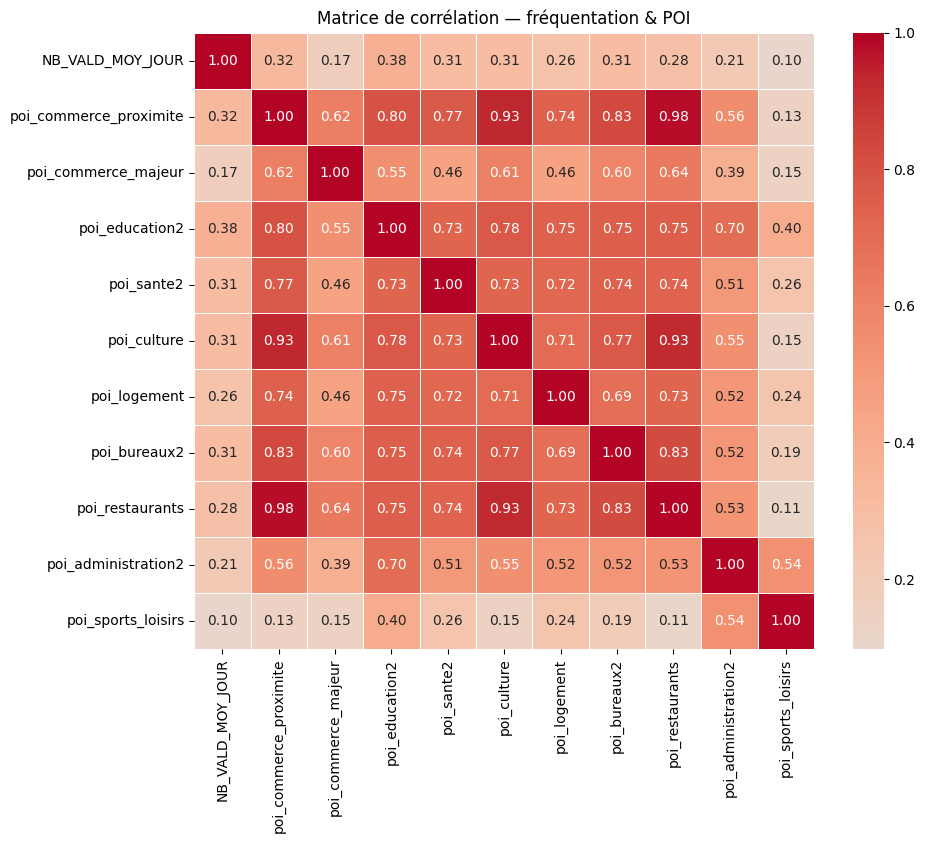

In [71]:
df_numerique = df_final[["NB_VALD_MOY_JOUR",
    "poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_restaurants",
    "poi_administration2",
    "poi_sports_loisirs"]]
    
# Heatmap
corr = df_numerique.corr()

plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True,          # valeurs écrites
    cmap="coolwarm",     # palette lisible
    center=0,            # neutre = pas de lien
    linewidths=.7,       # séparation visuelle
    fmt=".2f"            # arrondi lisible
)
plt.title("Matrice de corrélation — fréquentation & POI")
plt.show()

Globalement les corrélations entre les POI sont assez similaires à ce qu'on trouvait pour le réseau ferré, mais on a certaines tendances encore plus fortes : corrélation de 0.98 entre commerce_proximite et restaurants, et d'autres nouvelles tendances inattendues comme culture et commerce_proximite qui sont très corrélés.

Régression avec tous les poi, en excluant restaurants à cause de la trop grosse corrélation avec commerce_proximite

In [72]:
df = df_final.copy()

# remplacer inf / -inf par NaN
df_clean = df.replace([np.inf, -np.inf], np.nan)

# supprimer toutes les lignes contenant un NaN
df_clean = df_clean.dropna()

y = df_clean["NB_VALD_MOY_JOUR"]
y_log = (df_clean["NB_VALD_MOY_JOUR"] + 1)
X = df_clean[["poi_commerce_proximite",
    "poi_commerce_majeur",
    "poi_education2",
    "poi_sante2",
    "poi_culture",
    "poi_logement",
    "poi_bureaux2",
    "poi_administration2",
    "poi_sports_loisirs"]]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       NB_VALD_MOY_JOUR   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     35.41
Date:                Thu, 18 Dec 2025   Prob (F-statistic):           1.06e-57
Time:                        13:33:21   Log-Likelihood:                -16909.
No. Observations:                1688   AIC:                         3.384e+04
Df Residuals:                    1678   BIC:                         3.389e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    141

Les seuls coefficients significatifs sont ceux de : logement, sante2, education2, commerce_majeur.

In [73]:
y_log = np.log(y+1)
df_clean["log_log"] = np.log(df_clean["poi_logement"]+1)
df_clean["log_sante"] = np.log(df_clean["poi_sante2"] +1)
df_clean["log_educ"] = np.log(df_clean["poi_education2"]+1)
df_clean["log_maj"] = np.log(df_clean["poi_commerce_majeur"]+1)

X_log = df_clean[["log_log","log_sante","log_educ","log_maj"]]

X_log = sm.add_constant(X_log)

model = sm.OLS(y_log, X_log).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       NB_VALD_MOY_JOUR   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     195.8
Date:                Thu, 18 Dec 2025   Prob (F-statistic):          5.89e-138
Time:                        13:33:21   Log-Likelihood:                -3381.8
No. Observations:                1688   AIC:                             6774.
Df Residuals:                    1683   BIC:                             6801.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8331      0.155     18.250      0.0

On a un R² assez similaire à ce qu'on avait sur le réseau ferré.

### Autre limite

Ainsi, les lignes de bus sont très nombreuses et très variées, et d'autres variables que l'on ne prend pas en compte avec nos données semblent pouvoir expliquer leur fréquentation.

Par exemple, en reprenant le classement des lignes du réseau de surface les plus fréquentées, dans le top10 apparaissent deux lignes de bus parisiennes : le 62 et le 60. Ces deux lignes desservent des zones géographiquement différentes (le Sud pour le 62 et le Nord-Est pour le 60) mais quand on regarde leur trajet, ces deux lignes ont un point commun : elles desservent des zones mal desservies par le métro et ont un trajet en rocade. Alors que le réseau de métro de Paris est principalement radial (un problème que va tenter de résoudre la ligne 15 du Grand Paris Express), le 62 et le 60 permettent des trajets qui sont contraignants à faire en métro. Au vu de la très forte densité du réseau de métro parisien, ces cas sont rares.
Ces deux lignes ne desservent pas de grand pôle, elles répondent surtout à une demande résidentielle qui n'a pas de meilleure alternative.

Ainsi, un critère que l'on pourrait prendre en compte pour expliquer la fréquentation des lignes de bus serait le manque d'alternatives ferrées. Cependant, cela semble difficile à mesurer.